# V-Unet v1.1 
Training condition: 

- Pre-train with 400 LUS (train-test-split of 0.8) 
  - Learning rate 1e-5, trained with 100 epochs
- Fine-tune with the same LUS dataset, with 5 fold cross validation
  - Learning rate 5e-6, trained with 100 epochs

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/Lung_Segmentation

/content/gdrive/MyDrive/Lung_Segmentation


In [ ]:
from DataPreprocessing import *
from ValidationAndPrediction import * 
from Model import *
import os
import re
import numpy as np
import pandas as pd
import natsort
import matplotlib.pyplot as plt

import cv2
from tqdm import tqdm
from glob import glob
from PIL import Image
from skimage.transform import resize
from sklearn.model_selection import train_test_split, KFold

In [ ]:
tf.__version__

'2.6.0'

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2709395664164642573
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11345264640
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6502884834019540249
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


# 1. LUS Data Exploration 

Preparing the training dataset list

In [ ]:
train_image_path = 'Lung_seg_data/NEW_TIF_IMG'
train_mask_path = 'Lung_seg_data/NEW_TIF_MASK'
train_images, train_masks = train_filepath_list(train_image_path, train_mask_path)
print('Number of train dataset: ', len(train_images))

Number of train dataset:  200


Display one of the images and masks as example:

Image shape:  (960, 128)
Mask shape:  (960, 128)


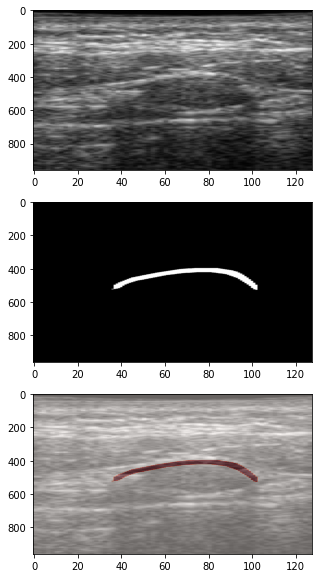

In [ ]:
image_display(train_images, train_masks, 0)

# 2. Data Preprocess: Data Augmentation
**Create double number of image and mask copies using horizontal flip**
- use function `horizontal_flip` to create copies
- use function `gen_filepath_list` to return a list of filepath of generated images and masks

In [ ]:
gen_images_filepath = 'Lung_seg_data/NEW_CODES/newcode_gen_images'
gen_masks_filepath = 'Lung_seg_data/NEW_CODES/newcode_gen_masks'
gen_images, gen_masks = train_filepath_list(gen_images_filepath, gen_masks_filepath)
print('Number of train images: ', len(gen_images))
print('Number of train masks: ', len(gen_masks))
print(gen_images)

Number of train images:  200
Number of train masks:  200
['Lung_seg_data/NEW_CODES/newcode_gen_images/img_lung_pos2_5_flipped.tif', 'Lung_seg_data/NEW_CODES/newcode_gen_images/img_lung_pos2_10_flipped.tif', 'Lung_seg_data/NEW_CODES/newcode_gen_images/img_lung_pos2_15_flipped.tif', 'Lung_seg_data/NEW_CODES/newcode_gen_images/img_lung_pos2_20_flipped.tif', 'Lung_seg_data/NEW_CODES/newcode_gen_images/img_lung_pos2_25_flipped.tif', 'Lung_seg_data/NEW_CODES/newcode_gen_images/img_lung_pos2_30_flipped.tif', 'Lung_seg_data/NEW_CODES/newcode_gen_images/img_lung_pos2_35_flipped.tif', 'Lung_seg_data/NEW_CODES/newcode_gen_images/img_lung_pos2_40_flipped.tif', 'Lung_seg_data/NEW_CODES/newcode_gen_images/img_lung_pos2_45_flipped.tif', 'Lung_seg_data/NEW_CODES/newcode_gen_images/img_lung_pos2_50_flipped.tif', 'Lung_seg_data/NEW_CODES/newcode_gen_images/img_lung_pos2_105_flipped.tif', 'Lung_seg_data/NEW_CODES/newcode_gen_images/img_lung_pos2_110_flipped.tif', 'Lung_seg_data/NEW_CODES/newcode_gen_imag

Display one of the flipped images and masks as example:

Image shape:  (960, 128, 3)
Mask shape:  (960, 128, 3)


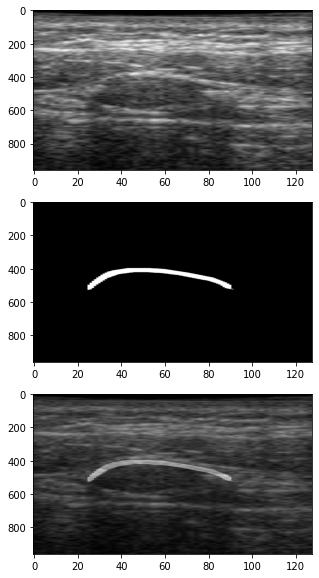

In [ ]:
image_display(gen_images, gen_masks, 0)

**Creating a pandas Dataframe for all the filepaths of both original and generated dataset**
- use function `train_dataframe`

In [ ]:
aug_images = train_images + gen_images
aug_masks = train_masks + gen_masks

df = train_dataframe(aug_images, aug_masks)
display(df)

,filename,mask
0,Lung_seg_data/NEW_TIF_IMG/img_lung_pos2_905.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos2_905.tif
1,Lung_seg_data/NEW_TIF_IMG/img_lung_pos3_650.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos3_650.tif
2,Lung_seg_data/NEW_CODES/newcode_gen_images/img...,Lung_seg_data/NEW_CODES/newcode_gen_masks/mask...
3,Lung_seg_data/NEW_TIF_IMG/img_lung_pos2_135.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos2_135.tif
4,Lung_seg_data/NEW_CODES/newcode_gen_images/img...,Lung_seg_data/NEW_CODES/newcode_gen_masks/mask...
...,...,...
395,Lung_seg_data/NEW_TIF_IMG/img_lung_pos3_205.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos3_205.tif
396,Lung_seg_data/NEW_CODES/newcode_gen_images/img...,Lung_seg_data/NEW_CODES/newcode_gen_masks/mask...
397,Lung_seg_data/NEW_CODES/newcode_gen_images/img...,Lung_seg_data/NEW_CODES/newcode_gen_masks/mask...
398,Lung_seg_data/NEW_TIF_IMG/img_lung_pos2_625.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos2_625.tif


**Use `ImageDataGenerator` for data augmentation**
- use function `train_generator`
- can generate images and masks at the same time using the same seed for the image and masks generators to ensure same transformation between corresponding images and masks 
- to be used in model training process

In [ ]:
# Defining data augmentation dictionary 
train_generator_args = dict(rotation_range=0.15,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

# Redefine the input size of the images 
width = 256
height = 256
channel = 3

# To visualize the results of generator: set save_to_dir = "your path"
aug_img_dir = None
aug_mask_dir = None
aug_img_prefix = None
aug_mask_prefix = None
aug_format = None

# 3. Transfer Learning with U-Net
**Use of pre-trained model (VGG16) for transfer learning**

see function `TL_unet_model(input_shape)`, which has VGG16 encoder frozen

In [ ]:
input_shape = (height, width, channel)
#output_shape = (256, 256, 1)
K.clear_session()
unet_model = TL_unet_model(input_shape)


58900480/58889256 [==============================] - 1s 0us/step
(None, 16, 16, 512)
(None, 32, 32, 512)
(None, 64, 64, 256)
(None, 128, 128, 128)
(None, 256, 256, 64)
(None, 256, 256, 1)


In [ ]:
unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

Display the layers status (trainable or non-trainable)

In [ ]:
layers = [(layer, layer.name, layer.trainable) for layer in unet_model.layers]
unet_model_df = pd.DataFrame(layers, columns=["Layer Type", "Layer Name", "Layer Trainable"])

display(unet_model_df)

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at...,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0...,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0...,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0...,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0...,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0...,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0...,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0...,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0...,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0...,block3_conv3,False


# 4. Training the TL U-Net model

Splitting the dataset: 80% for training, 20% for validation and testing

In [ ]:
kf = KFold(n_splits = 5, shuffle=True)
for k, (train_index, test_index) in enumerate(kf.split(df)):
    train_df = df.iloc[train_index]
    test_df = df.iloc[test_index]

print("Training Dataset:")
display(train_df)
print("Validation and Testing Dataset")
display(test_df)

Training Dataset:


,filename,mask
1,Lung_seg_data/NEW_TIF_IMG/img_lung_pos3_650.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos3_650.tif
2,Lung_seg_data/NEW_CODES/newcode_gen_images/img...,Lung_seg_data/NEW_CODES/newcode_gen_masks/mask...
3,Lung_seg_data/NEW_TIF_IMG/img_lung_pos2_135.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos2_135.tif
6,Lung_seg_data/NEW_TIF_IMG/img_lung_pos3_625.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos3_625.tif
7,Lung_seg_data/NEW_CODES/newcode_gen_images/img...,Lung_seg_data/NEW_CODES/newcode_gen_masks/mask...
...,...,...
395,Lung_seg_data/NEW_TIF_IMG/img_lung_pos3_205.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos3_205.tif
396,Lung_seg_data/NEW_CODES/newcode_gen_images/img...,Lung_seg_data/NEW_CODES/newcode_gen_masks/mask...
397,Lung_seg_data/NEW_CODES/newcode_gen_images/img...,Lung_seg_data/NEW_CODES/newcode_gen_masks/mask...
398,Lung_seg_data/NEW_TIF_IMG/img_lung_pos2_625.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos2_625.tif


Validation and Testing Dataset


,filename,mask
0,Lung_seg_data/NEW_TIF_IMG/img_lung_pos2_905.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos2_905.tif
4,Lung_seg_data/NEW_CODES/newcode_gen_images/img...,Lung_seg_data/NEW_CODES/newcode_gen_masks/mask...
5,Lung_seg_data/NEW_TIF_IMG/img_lung_pos2_745.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos2_745.tif
16,Lung_seg_data/NEW_TIF_IMG/img_lung_pos2_5.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos2_5.tif
27,Lung_seg_data/NEW_TIF_IMG/img_lung_pos2_125.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos2_125.tif
...,...,...
379,Lung_seg_data/NEW_CODES/newcode_gen_images/img...,Lung_seg_data/NEW_CODES/newcode_gen_masks/mask...
380,Lung_seg_data/NEW_TIF_IMG/img_lung_pos2_230.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos2_230.tif
390,Lung_seg_data/NEW_CODES/newcode_gen_images/img...,Lung_seg_data/NEW_CODES/newcode_gen_masks/mask...
391,Lung_seg_data/NEW_CODES/newcode_gen_images/img...,Lung_seg_data/NEW_CODES/newcode_gen_masks/mask...


 **Model training**

In [ ]:
batch_size = 20
epochs = 100

# Defining the train generator and test generator: 
train_gen = train_generator(train_df, batch_size, 
                          None, 
                          train_generator_args,
                          aug_img_dir, aug_mask_dir, 
                          aug_img_prefix, aug_mask_prefix,
                          aug_format,
                          (height, width))

test_gen = train_generator(test_df, batch_size,
                           None, 
                           dict(),
                           None, None, None, None, None, 
                           (height, width))

# Train the model with `.fit_generator()`
unet_model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, 
                    metrics=[iou, dice_coef, 'binary_accuracy'])

checkpoint_path = 'V_Unet/model_v1_1/unet_lung_segmentation.hdf5'

pretrain_csvlogger = CSVLogger(filename='V_Unet/model_v1_1/pretrain_training_log.csv', separator=",", append=True)

model_checkpoint = ModelCheckpoint(checkpoint_path,  
                                    verbose=1,
                                    monitor='val_loss',
                                    save_best_only=True)

callbacks_list = [model_checkpoint, pretrain_csvlogger]

history = unet_model.fit_generator(train_gen,
                                    steps_per_epoch=len(df)//batch_size,
                                    epochs=epochs,
                                    callbacks=callbacks_list,
                                    validation_data = test_gen, 
                                    validation_steps = len(test_df)//batch_size,
                                    verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Found 320 validated image filenames.
Found 320 validated image filenames.
Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: -0.0466 - iou: 0.0238 - dice_coef: 0.0466 - binary_accuracy: 0.8195Found 80 validated image filenames.
Found 80 validated image filenames.
20/20 [==============================] - 184s 9s/step - loss: -0.0466 - iou: 0.0238 - dice_coef: 0.0466 - binary_accuracy: 0.8195 - val_loss: -0.0503 - val_iou: 0.0258 - val_dice_coef: 0.0503 - val_binary_accuracy: 0.8256

Epoch 00001: val_loss improved from inf to -0.05035, saving model to model_v1_1/unet_lung_segmentation.hdf5
Epoch 2/100
20/20 [==============================] - 34s 2s/step - loss: -0.0584 - iou: 0.0301 - dice_coef: 0.0584 - binary_accuracy: 0.8956 - val_loss: -0.0669 - val_iou: 0.0346 - val_dice_coef: 0.0669 - val_binary_accuracy: 0.9521

Epoch 00002: val_loss improved from -0.05035 to -0.06689, saving model to model_v1_1/unet_lung_segmentation.hdf5
Epoch 3/100
20/20 [=====================

TypeError: ignored

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Found 80 validated image filenames.
Found 80 validated image filenames.
4/4 [==============================] - 4s 723ms/step - loss: -0.8053 - iou: 0.6740 - dice_coef: 0.8053 - binary_accuracy: 0.9921
Evaluation scores from pretrained model:
Accuracy:  [0.9920988082885742]
Loss:  [-0.8052634000778198]
Dice coefficient:  [0.8052634596824646]
IOU:  [0.6740193367004395]


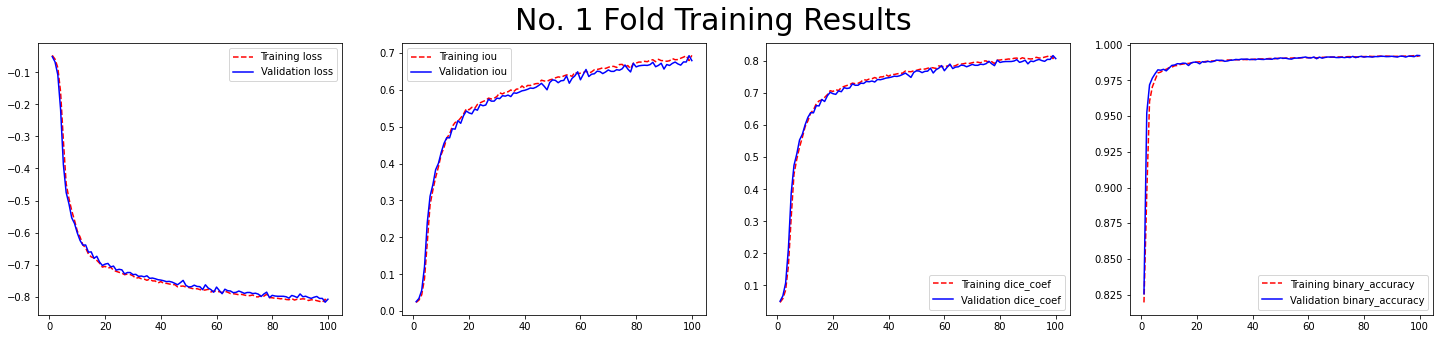

In [ ]:
histories = []
losses = []
accuracies = []
dicecoefs = []
ious = []

TLmodel = load_model(checkpoint_path, 
                     custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})
TLmodel.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss,
                metrics=[iou, dice_coef, 'binary_accuracy'])

evaluate_gen = train_generator(test_df, batch_size,
                               None, 
                               dict(),
                               None, None, None, None, None, 
                               (height, width))

results = TLmodel.evaluate_generator(evaluate_gen, 
                                    steps=len(test_df)//batch_size,
                                    verbose=1)
results = dict(zip(TLmodel.metrics_names,results))

histories.append(history)
accuracies.append(results['binary_accuracy'])
losses.append(results['loss'])
dicecoefs.append(results['dice_coef'])
ious.append(results['iou'])

print('Evaluation scores from pretrained model:')
print('Accuracy: ', accuracies)
print('Loss: ', losses)
print('Dice coefficient: ', dicecoefs)
print('IOU: ', ious)

plot_histories(histories)

---------------------------------------------------------------------------
---------------------------------------------------------------------------

# 5. Fine-tuning 
1. Unfreeze the contracting path
2. Apply KFold cross validation (k=5) 
3. Evaluation metrics: dice score, iou

- For unfreezing use function `finetune_unfreezeall`
    - take the base model (pretrained one) and unfreeze all the layers 

In [ ]:
TL_checkpoint_path = 'V_Unet/model_v1_1/unet_lung_segmentation.hdf5'
TLmodel = load_model(TL_checkpoint_path, 
                     custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})
FTmodel = finetune_unfreezeall(input_shape, TLmodel)

FTmodel.summary() # should have no non-trainable parameters 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

Apply KFold cross validation (k=5)

In [ ]:
kf_histories = []
kf_losses = []
kf_accuracies = []
kf_dicecoefs = []
kf_ious = []

# same batch size and epochs
epochs = 100
batch_size = 20

# added KFold in here:
kf = KFold(n_splits = 5, shuffle=False)

for k, (train_index, test_index) in enumerate(kf.split(df)):
    kf_train_df = df.iloc[train_index]
    kf_test_df = df.iloc[test_index]
    
    kf_train_gen = train_generator(kf_train_df, batch_size, 
                                None, 
                                train_generator_args,
                                None, None, None, None, None,
                                (height, width))

    kf_test_gen = train_generator(kf_test_df, batch_size,
                               None, 
                               dict(),
                               None, None, None, None, None, 
                               (height, width))
    
    TLmodel = load_model(TL_checkpoint_path, 
                     custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})
    
    kf_model = finetune_unfreezeall(input_shape, TLmodel)
    kf_model.compile(optimizer=Adam(lr=5e-6), loss=dice_coef_loss,
                    metrics=[iou, dice_coef, 'binary_accuracy'])
    
    kf_checkpoint_path = 'V_Unet/model_v1_1/' + str(k+1) + '_KFold_ft_unet_lung_segmentation_new.hdf5'
    
    kf_model_checkpoint = ModelCheckpoint(kf_checkpoint_path,
                                         verbose=1, 
                                         monitor='val_loss',
                                         save_best_only=True)

    kf_csvlogger = CSVLogger(filename='V_Unet/model_v1_1/'+str(k+1)+'KF_training_log.csv', separator=",", append=True)
    
    kf_callbacks_list = [kf_model_checkpoint, kf_csvlogger]
    
    print('------------------------------------------------------------------------')
    print('Training for fold ', k+1)
    
    kf_history = kf_model.fit_generator(kf_train_gen, 
                                       steps_per_epoch=len(kf_train_df)//batch_size,
                                       epochs=epochs,
                                       callbacks=kf_callbacks_list,
                                       validation_data = kf_test_gen, 
                                       validation_steps = len(kf_test_df)//batch_size,
                                       verbose=1)
    
    KFmodel = load_model(kf_checkpoint_path, 
                       custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})
    KFmodel.compile(optimizer=Adam(lr=5e-6), loss=dice_coef_loss,
                    metrics=[iou, dice_coef, 'binary_accuracy'])
    
    
    # another generator for evaluate_generator 
    kf_evaluate_gen = train_generator(kf_test_df, batch_size,
                                   None,
                                   dict(),
                                   None, None, None, None, None,
                                   (height, width))
    
    kf_results = KFmodel.evaluate_generator(kf_evaluate_gen, 
                                      steps=len(kf_test_df)//batch_size)
    kf_results = dict(zip(KFmodel.metrics_names,kf_results))
    
    kf_histories.append(kf_history)
    kf_accuracies.append(kf_results['binary_accuracy'])
    kf_losses.append(kf_results['loss'])
    kf_dicecoefs.append(kf_results['dice_coef'])
    kf_ious.append(kf_results['iou'])
 

kf_results_df = pd.DataFrame(data={'Accuracy': kf_accuracies, 'Loss': kf_losses, 'Dice coef': kf_dicecoefs, 'IOU': kf_ious},
                             dtype = np.float64)
kf_results_df.to_csv(path_or_buf='V_Unet/model_v1_1/kf5_results.csv')
display(kf_results_df)

plot_histories(kf_histories)

# Print all the evaluation scores: 
print('Evaluation scores from 5 Fold fine-tuning model:')
print('Accuracies : ', kf_accuracies)
print('Losses : ', kf_losses)
print('Dice coefficients : ', kf_dicecoefs)
print('IOUs : ', kf_ious)

print('')

print('Average accuracy : ', np.mean(np.array(kf_accuracies)))
print('Average loss : ', np.mean(np.array(kf_losses)))
print('Average dice coefficient : ', np.mean(np.array(kf_dicecoefs)))
print('Average IOU : ', np.mean(np.array(kf_ious)))

print('')

print('SD of accuracy : ', np.std(np.array(kf_accuracies)))
print('SD of loss : ', np.std(np.array(kf_losses)))
print('SD of dice coefficient : ', np.std(np.array(kf_dicecoefs)))
print('SD of iou : ', np.std(np.array(kf_ious)))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


------------------------------------------------------------------------
Training for fold  1
Found 320 validated image filenames.
Found 320 validated image filenames.
Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: -0.7933 - iou: 0.6582 - dice_coef: 0.7933 - binary_accuracy: 0.9912Found 80 validated image filenames.
Found 80 validated image filenames.
16/16 [==============================] - 39s 2s/step - loss: -0.7933 - iou: 0.6582 - dice_coef: 0.7933 - binary_accuracy: 0.9912 - val_loss: -0.8144 - val_iou: 0.6871 - val_dice_coef: 0.8144 - val_binary_accuracy: 0.9915

Epoch 00001: val_loss improved from inf to -0.81444, saving model to model_v1_1/1_KFold_ft_unet_lung_segmentation_new.hdf5
Epoch 2/100
16/16 [==============================] - 37s 2s/step - loss: -0.8092 - iou: 0.6797 - dice_coef: 0.8092 - binary_accuracy: 0.9919 - val_loss: -0.8246 - val_iou: 0.7015 - val_dice_coef: 0.8246 - val_binary_accuracy: 0.9927

Epoch 00002: val_loss improved from -0.81444 

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Found 80 validated image filenames.
Found 80 validated image filenames.
------------------------------------------------------------------------
Training for fold  2
Found 320 validated image filenames.
Found 320 validated image filenames.
Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: -0.7960 - iou: 0.6618 - dice_coef: 0.7960 - binary_accuracy: 0.9913Found 80 validated image filenames.
Found 80 validated image filenames.
16/16 [==============================] - 39s 2s/step - loss: -0.7960 - iou: 0.6618 - dice_coef: 0.7960 - binary_accuracy: 0.9913 - val_loss: -0.8031 - val_iou: 0.6710 - val_dice_coef: 0.8031 - val_binary_accuracy: 0.9909

Epoch 00001: val_loss improved from inf to -0.80305, saving model to model_v1_1/2_KFold_ft_unet_lung_segmentation_new.hdf5
Epoch 2/100
16/16 [==============================] - 37s 2s/step - loss: -0.8110 - iou: 0.6823 - dice_coef: 0.8110 - binary_accuracy: 0.9919 - val_loss: -0.8128 - val_iou: 0.6849 - val_dice_coef: 0.8128 - va